<a href="https://colab.research.google.com/github/necronet/Notebooks/blob/master/colab/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# To make sure some classes are installed
!pip install tf-nightly --quiet

     |████████████████████████████████| 322.8MB 48kB/s 
     |████████████████████████████████| 3.0MB 39.4MB/s 
     |████████████████████████████████| 460kB 36.2MB/s 


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files
from google.colab import drive
tf.__version__

'2.4.0-dev20200703'

In [6]:
image_size = (180, 180)
batch_size = 32
seed = 20190510

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   113M      0  0:00:06  0:00:06 --:--:--  120M


In [9]:
!unzip -oq kagglecatsanddogs_3367a.zip
!ls

 gdrive			      'MSR-LA - 3467.docx'  'readme[1].txt'
 kagglecatsanddogs_3367a.zip   PetImages	     sample_data


In [5]:
!pwd

/content


In [6]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


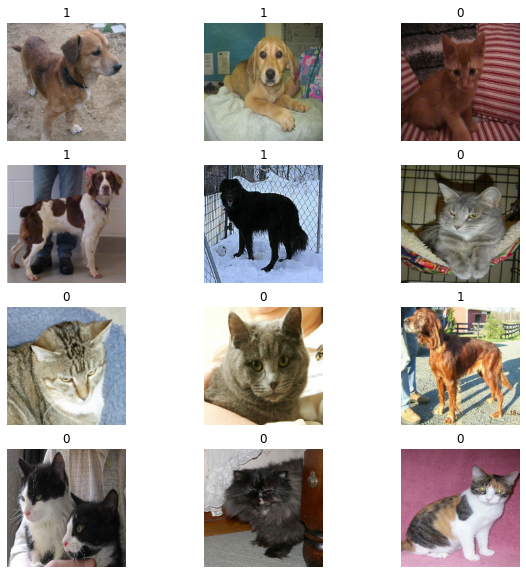

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

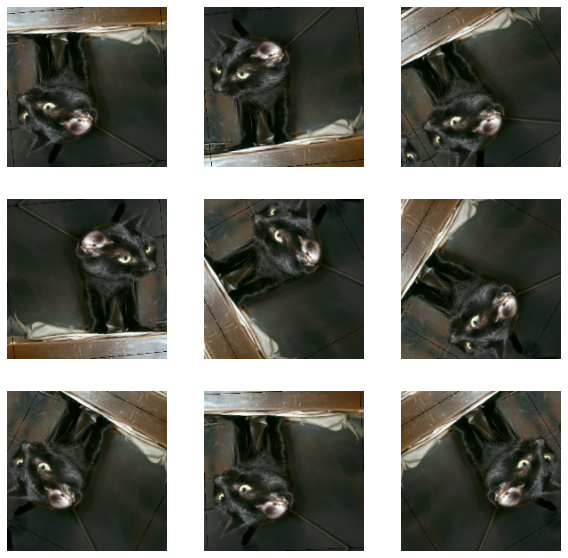

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomFlip("vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

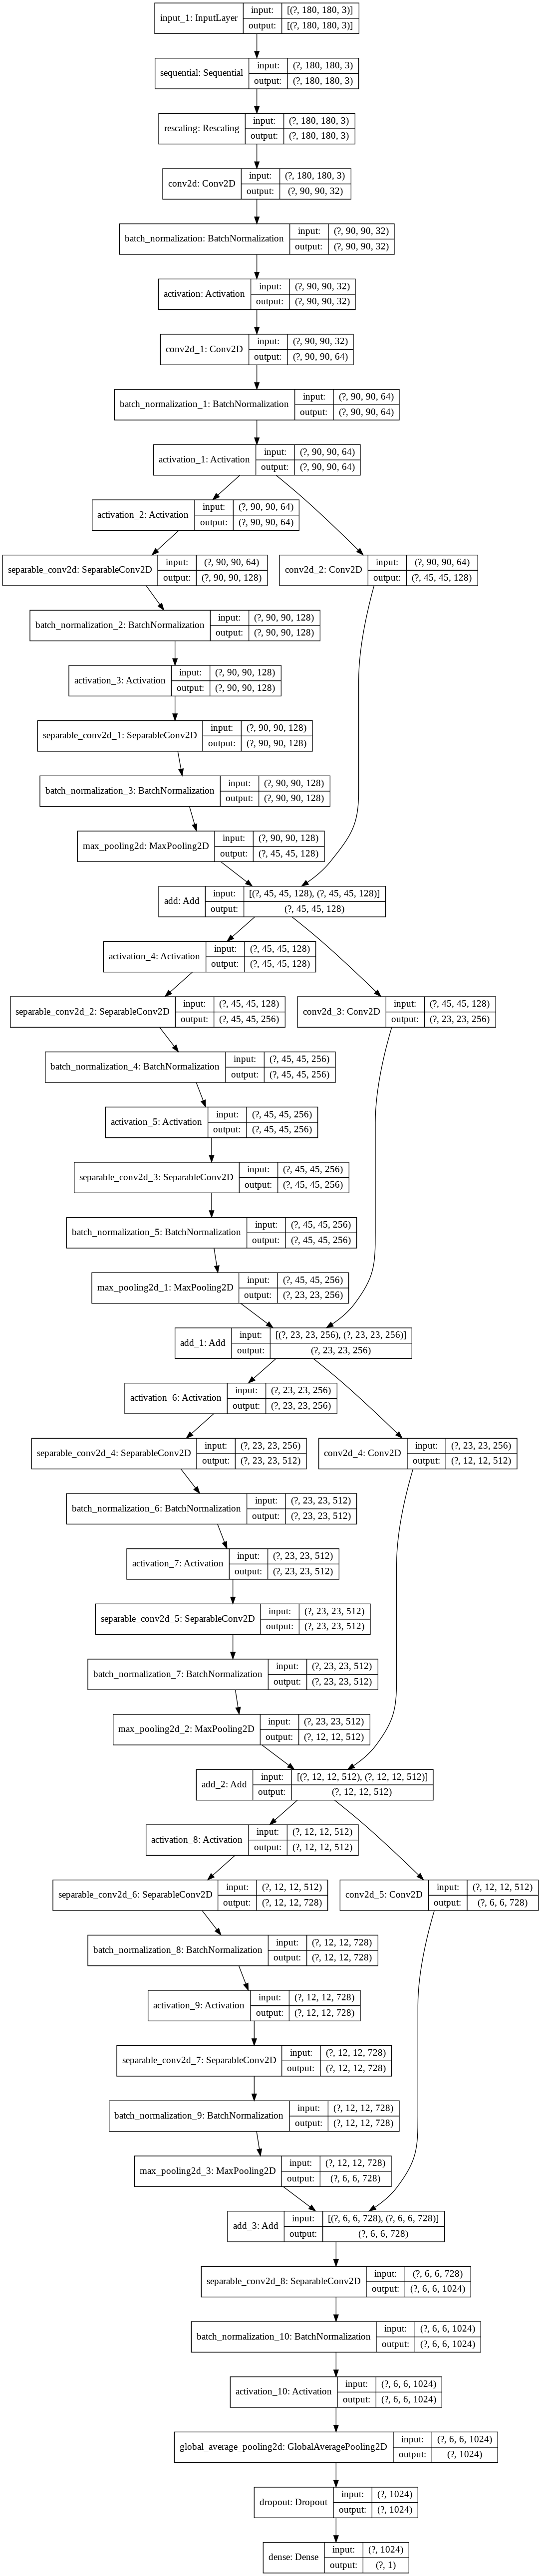

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [17]:
!ls 

 kagglecatsanddogs_3367a.zip   save_at_12.h5   save_at_1.h5    save_at_3.h5
 model.png		       save_at_13.h5   save_at_20.h5   save_at_4.h5
'MSR-LA - 3467.docx'	       save_at_14.h5   save_at_21.h5   save_at_5.h5
 PetImages		       save_at_15.h5   save_at_22.h5   save_at_6.h5
'readme[1].txt'		       save_at_16.h5   save_at_23.h5   save_at_7.h5
 sample_data		       save_at_17.h5   save_at_24.h5   save_at_8.h5
 save_at_10.h5		       save_at_18.h5   save_at_25.h5   save_at_9.h5
 save_at_11.h5		       save_at_19.h5   save_at_2.h5


In [13]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/25
586/586 [==============================] - 303s 516ms/step - loss: 0.6356 - accuracy: 0.6483 - val_loss: 0.5603 - val_accuracy: 0.7273
Epoch 2/25
586/586 [==============================] - 301s 514ms/step - loss: 0.5333 - accuracy: 0.7327 - val_loss: 0.7887 - val_accuracy: 0.5551
Epoch 3/25
586/586 [==============================] - 301s 513ms/step - loss: 0.4784 - accuracy: 0.7749 - val_loss: 0.6410 - val_accuracy: 0.6918
Epoch 4/25
586/586 [==============================] - 301s 513ms/step - loss: 0.4365 - accuracy: 0.7994 - val_loss: 1.1136 - val_accuracy: 0.5617
Epoch 5/25
586/586 [==============================] - 301s 513ms/step - loss: 0.3964 - accuracy: 0.8242 - val_loss: 0.5752 - val_accuracy: 0.7394
Epoch 6/25
586/586 [==============================] - 302s 515ms/step - loss: 0.3671 - accuracy: 0.8406 - val_loss: 0.4204 - val_accuracy: 0.8214
Epoch 7/25
586/586 [==============================] - 301s 513ms/step - loss: 0.3427 - accuracy: 0.8521 - val_loss: 0.5065 -

In [19]:
files.download('save_at_25.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
!ls 'gdrive/My Drive/Colab Notebooks/models'
model = tf.keras.models.load_model('gdrive/My Drive/Colab Notebooks/models/save_at_25.h5')

save_at_25.h5


In [29]:
testImagePath = "PetImages/Dog/2.jpg"
img = keras.preprocessing.image.load_img(testImagePath, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 0.56 percent cat and 99.44 percent dog.


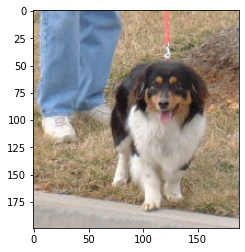

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(testImagePath)
imgplot = plt.imshow(img)